In [1]:
import cv2
import matplotlib.pyplot as plt
import math
from skimage.metrics import structural_similarity
import numpy as np
from sklearn.model_selection import train_test_split
import random

In [2]:
img = cv2.imread('BROWNSPOT1_092.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


In [3]:
new_img = cv2.GaussianBlur(img_rgb,(7,7),0)

In [4]:
mse = ((img_rgb.flatten()-new_img.flatten())**2).mean()
psnr = 10 * math.log10(255**2/mse)

In [5]:
structural_similarity(img_rgb,new_img,data_range=img_rgb.max()-img_rgb.min(),channel_axis=2)

0.5989727654007014

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import v2
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
import os
import torch.optim as optim

In [7]:
torch.cuda.is_available()

False

In [8]:
def preprocess():
    transforms = v2.Compose([
        v2.ToImage(),
        v2.Resize(512),
        v2.ToDtype(torch.float,scale=True)])
    return transforms


In [9]:
pre = preprocess()

In [10]:
class SRCNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3,64,kernel_size=9,stride=(1,1),padding=(2,2))

        self.conv2 = nn.Conv2d(64,32,kernel_size=1,stride=(1,1),padding=(2,2))

        self.conv3 = nn.Conv2d(32,3,kernel_size=5,stride=(1,1),padding=(2,2))

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)

        return x

In [11]:

def psnr(label, outputs, max_val=1.):

    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    diff = outputs - label
    rmse = math.sqrt(np.mean((diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

In [12]:
psnr(pre(img_rgb),pre(new_img))

30.503125263029144

In [13]:

# # Set figure size
# plt.figure(figsize=(15, 5))  # Adjust the width and height as needed

# # Plot the images
# plt.subplot(1, 3, 1)
# plt.imshow(img_rgb)
# plt.title("Original Image")  # Optional title
# plt.axis("off")             # Turn off axes

# plt.subplot(1, 3, 2)
# plt.imshow(resize_img)
# plt.title("Resized Image")  # Optional title
# plt.axis("off")

# plt.subplot(1, 3, 3)
# plt.imshow(low_res_img)
# plt.title("Low Res Image")  # Optional title
# plt.axis("off")

# # Show the plot
# plt.tight_layout()  # Adjust subplot spacing
# plt.show()


In [14]:
for im in os.listdir('Yellow Mosaic'):
    pth = os.path.join('Yellow Mosaic',im)
    img = cv2.imread(pth)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resize_img = cv2.resize(img_rgb,(100,100))
    low_res_img = cv2.resize(resize_img,(512,512),interpolation=cv2.INTER_CUBIC)
    plt.imsave('Down Sampled\\' + im,low_res_img)

In [15]:
dirs = []

for images_dir in os.listdir('Yellow Mosaic'):
    dirs.append(os.path.join(images_dir))


In [16]:
class Disease(Dataset):
    
    def __init__(self, dirs, transforms = None):
        super().__init__()
        self.dirs = dirs
        self.number = len(dirs)
        self.transforms = transforms

    def __getitem__(self, index):
        image = read_image(os.path.join('Down Sampled',self.dirs[index]))
        label = read_image(os.path.join('Yellow Mosaic',self.dirs[index]))
        # label = names_label.index(self.dirs[index].split('\\')[1])

        if self.transforms is not None:
            image = self.transforms(image)
            label = self.transforms(label)

        return image , label
    
    def __len__(self):
        return self.number

In [17]:
dataset = Disease(dirs,pre)

In [18]:
train_dataset, test_dataset= train_test_split(
    dataset,test_size=0.3)

In [19]:
train_dataloader = DataLoader(train_dataset,8,shuffle=True)
test_dataloader = DataLoader(test_dataset,8,shuffle=True)

In [45]:
model = SRCNN()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25
# device = 'cuda'

for epoch in range(num_epochs):
    # model.to(device)
    model.train()
    loss_sum = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader):    
        optimizer.zero_grad()
        pred = model(inputs)
        loss = loss_fn(pred,labels)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
    
    print(epoch,loss_sum/len(train_dataloader))

0 0.03806058191694319
1 0.008282209141179919
2 0.0063449094304814935
3 0.005505987768992781
4 0.004939968080725521
5 0.004420063365250826
6 0.004091937793418765
7 0.0037223532795906066
8 0.0034402503224555403
9 0.0032652218011207878
10 0.0031439480022527277
11 0.0030421752366237343


KeyboardInterrupt: 

In [36]:
model(test_dataset[0][0]).shape

torch.Size([3, 512, 512])

In [ ]:

psnr(test_dataset[0][0],model(test_dataset[0][1]))

25.12960203395844

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0075898105..1.0527579].


9.974779159540734 10.044686908960252


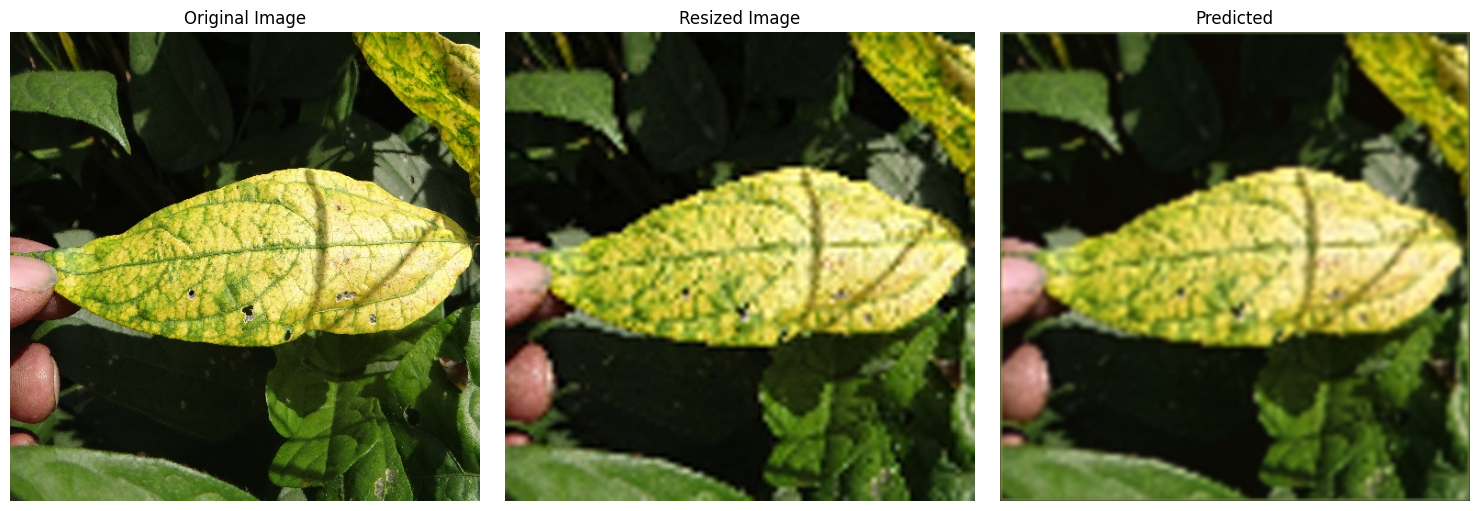

In [87]:
model.eval()
num = random.randint(0,68)
# Set figure size
plt.figure(figsize=(15, 5))  # Adjust the width and height as needed

# Plot the images
plt.subplot(1, 3, 1)
plt.imshow(train_dataset[num][1].permute(1,2,0).numpy())
plt.title("Original Image")  # Optional title
plt.axis("off")             # Turn off axes

plt.subplot(1, 3, 2)
plt.imshow(train_dataset[num][0].permute(1,2,0).numpy())
plt.title("Resized Image")  # Optional title
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(model(train_dataset[num][0]).detach().permute(1,2,0).numpy())
plt.title("Predicted")  # Optional title
plt.axis("off")

print(psnr(train_dataset[num][0],train_dataset[0][1]),psnr(train_dataset[num][0],model(train_dataset[0][1])))
# Show the plot
plt.tight_layout()  # Adjust subplot spacing
plt.show()